# Example Notebook

Reproducing Figure 2 of Amm & Viljanen

In [1]:
import numpy as np
from pySECS import SECS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Radius of Earth
R_E = 6371e3

# Pole of the current system at the North Pole
sec_loc = np.array([90., 0., R_E + 100e3])

# Set up the current system
system = SECS(sec_df_loc=sec_loc)

In [3]:
system.fit_unit_currents()
# Scale the system corresponding to Figure 2 (10 kA)
system.sec_amps *= 10000
system.sec_amps

array([[10000.]])

In [4]:
N = 1000
pred_loc = np.zeros(shape=(N, 3))
angles = np.linspace(0, 45, N)

pred_loc[:,0] = 90-angles
pred_loc[:,2] = R_E

B_pred = system.predict(pred_loc=pred_loc)
J_pred = system.predict(pred_loc=pred_loc, J=True)

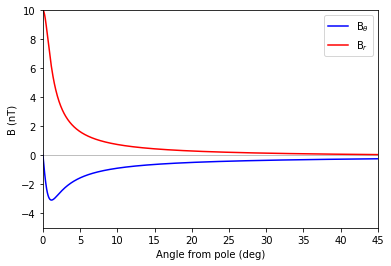

In [5]:
# B_theta == -Bx == -B_pred[:,0]
# Convert to nT (1e9)
B_theta = -B_pred[:,0]*1e9
# B_r == Bz = B_pred[:,2]
B_r = B_pred[:,2]*1e9

fig, ax = plt.subplots()

ax.plot(angles, B_theta, c='b', label=r'B$_{\theta}$')
ax.plot(angles, B_r, c='r', label=r'B$_r$')
ax.legend(loc='upper right')
ax.set_xlim(angles[0], angles[-1])
ax.set_ylim(-5, 10)
ax.set_xlabel('Angle from pole (deg)')
ax.set_ylabel('B (nT)')
ax.axhline(0., c='k', alpha=0.5, linewidth=0.5)